# Baseline improvements

### Imports

In [ ]:
import torch
from torch import nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import torch.nn.init as init
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import matplotlib_inline.backend_inline
import matplotlib
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from google.colab import drive
import gc

### Mounting Google Drive

In [ ]:
drive.mount('/content/drive/', force_remount=True)

# Define the root folder paths
GDrivePath = '/content/drive/MyDrive/'

# Specify the folder path
folderpath = GDrivePath + 'Colab Notebooks/CVPR2023/Progetto_CV&PR_Finale/'


# Define folder paths for train and test images
train_filepath = folderpath + 'train/'
test_filepath = folderpath + 'test/'

Mounted at /content/drive/


### Import some modules made by us

In [ ]:
# Change directory
os.chdir(folderpath)
!pwd

/content/drive/.shortcut-targets-by-id/1kPgTEfTvZTcmDVpGZlv2hkZkZVo76yNX/Progetto_CV&PR_Finale


In [ ]:
from datasets_utilities import show_images, load_images_from_folder
################
from datasets_utilities import class_mapping
###############
from training_utilities import train_CNN, train_one_epoch, accuracy, plot_loss_acc

## Dataloaders initialization and data augmentation

In [ ]:
# Transform to resize images to 64x64 pixels
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 255.0)  # Rescale pixel values back to [0, 255]
])

In [ ]:
# Function to generate new images by horizontally flipping the given ones
def flip_images(set):
    new_images=[]
    images_to_flip=set.copy()
    for image in images_to_flip:
      new_images.append(torch.flip(image, dims=[2]) ) # 2 corresponds to the width axis
    return new_images

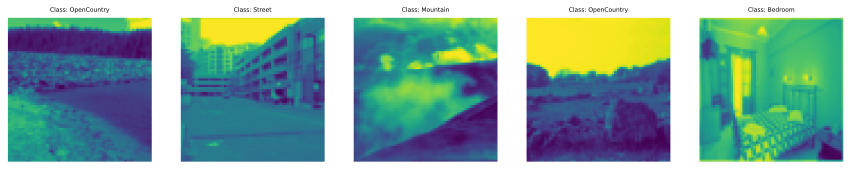

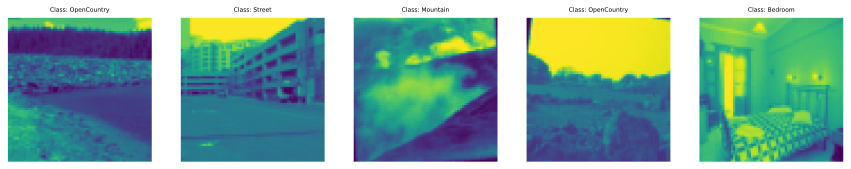

In [ ]:
# Creation of an augmented train_loader with horizontal flips and random crops

batch_size = 32

# Transform to extraxt random rotated crops and resize them to 64x64 pixels
transform_with_crop = transforms.Compose([
    transforms.RandomRotation(degrees=(-10, 10)), # Random rotation between -10 and 10 degrees
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.7, 1.0)), # Random crop of a portion at least 70% of the original image
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 255.0)  # Rescale pixel values back to [0, 255]
])

# Transform needed to load images as they are
transform_identity = transforms.Compose([])

# Load training and test images
train_set, train_labels = load_images_from_folder(train_filepath, transform_identity) # Loaded without trasformations
test_set, test_labels = load_images_from_folder(test_filepath, transform)

gc.collect()

# Test set remains the same
test_set = torch.utils.data.TensorDataset(torch.stack(test_set), torch.tensor(test_labels))
test_set = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)


# Split into training (85%) and validation (15%) sets
train_set, val_set, train_labels, val_labels = train_test_split(
    train_set, train_labels, test_size=0.15, random_state=42, stratify=train_labels
)

gc.collect()

# Validation set will not be augmented
val_set = [transform(image) for image in val_set]
val_set = torch.utils.data.TensorDataset(torch.stack(val_set), torch.tensor(val_labels))
val_set = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

# Train-set augmentation
train_cropped_set = [transform_with_crop(image) for image in train_set]
train_set = [transform(image) for image in train_set]

show_images(train_set, train_labels, num_images=5)
show_images(train_cropped_set, train_labels, num_images=5)

# Merge in a unique train-set
train_set= train_set + train_cropped_set
# Free space for memory optimization
train_cropped_set= None
gc.collect()

# Labels
train_labels = train_labels + train_labels

# Add flipped images to the training set
train_set = train_set + flip_images(train_set)
train_labels = train_labels+train_labels

gc.collect()

# Dataloaders
train_set = torch.utils.data.TensorDataset(torch.stack(train_set), torch.tensor(train_labels))
train_set = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [ ]:
# Dataframe for saving results of all experiments
results_df = pd.DataFrame()

### CNN_2

In [ ]:
# An improved version of CNN_1 with the addition of batch normalization, dropout, standard deviation tuning and increasing size of covolutional kernels
class CNN_2(nn.Module):
    def __init__(self, initial_weights_std): # User can chose standard deviation to initialize weights
        super(CNN_2, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout1 = nn.Dropout(p=0.25)

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout2 = nn.Dropout(p=0.25)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=7, padding=3)
        self.bn3 = nn.BatchNorm2d(32)
        self.relu3 = nn.ReLU()

        self.dropout3 = nn.Dropout(p=0.25)

        self.fc4 = nn.Linear(32 * 16 *16, 15)

        #self.softmax5 = nn.Softmax(dim=1) # Unnecessary if Cross Entropy is used as loss function

        self.initial_weigths_std = initial_weights_std

        self.initialize_weights()


    # Function for weights initialization
    def initialize_weights(self):
        for m in self.modules(): # Iteration over CNN_1 layers (modules)
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear): # Only convolutional and fully connected layers are considered, max pools and ReLUs do not have weights
                init.normal_(m.weight, mean=0, std=self.initial_weigths_std) # Normal distribution to initialize weights
                init.constant_(m.bias, 0) # Biases are initialized at 0


    # Forward pass through the layers
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.dropout3(x)

        x = x.view(-1, 32 * 16 * 16) # Flatten the output for the fully connected layer
        x = self.fc4(x)

        #x = self.softmax5(x)

        return x

#### Testing CNN_2

Staring epoch   0 ...
   ACCURACY: train 37.3 % | validation 38.3 %
       LOSS: train  2.084 | validation  2.404
Staring epoch   1 ...
   ACCURACY: train 57.7 % | validation 41.8 %
       LOSS: train  1.337 | validation  1.847
Staring epoch   2 ...
   ACCURACY: train 64.6 % | validation 55.9 %
       LOSS: train  1.056 | validation  1.699
Staring epoch   3 ...
   ACCURACY: train 71.9 % | validation 51.2 %
       LOSS: train  0.826 | validation  2.044
Staring epoch   4 ...
   ACCURACY: train 76.8 % | validation 45.7 %
       LOSS: train  0.677 | validation  2.109
Staring epoch   5 ...
   ACCURACY: train 78.9 % | validation 40.2 %
       LOSS: train  0.622 | validation  3.206
Staring epoch   6 ...
   ACCURACY: train 81.3 % | validation 58.2 %
       LOSS: train  0.540 | validation  1.523
Staring epoch   7 ...
   ACCURACY: train 84.7 % | validation 37.9 %
       LOSS: train  0.471 | validation  2.422
Staring epoch   8 ...
   ACCURACY: train 85.2 % | validation 52.3 %
       LOSS: train  

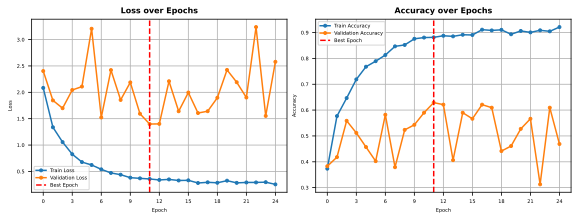



____________________________________________________________________________________________________________
TEST-SET STATISTICS:
Accuracy of the network on the test set: 63 %


Staring epoch   0 ...
   ACCURACY: train 31.6 % | validation 18.8 %
       LOSS: train  2.278 | validation  3.017
Staring epoch   1 ...
   ACCURACY: train 51.2 % | validation 42.2 %
       LOSS: train  1.485 | validation  2.139
Staring epoch   2 ...
   ACCURACY: train 60.6 % | validation 43.8 %
       LOSS: train  1.171 | validation  1.870
Staring epoch   3 ...
   ACCURACY: train 68.8 % | validation 41.0 %
       LOSS: train  0.924 | validation  1.824
Staring epoch   4 ...
   ACCURACY: train 73.6 % | validation 62.9 %
       LOSS: train  0.802 | validation  1.271
Staring epoch   5 ...
   ACCURACY: train 76.7 % | validation 50.8 %
       LOSS: train  0.682 | validation  1.573
Staring epoch   6 ...
   ACCURACY: train 80.2 % | validation 57.4 %
       LOSS: train  0.585 | validation  1.482
Staring epoch   7 ...


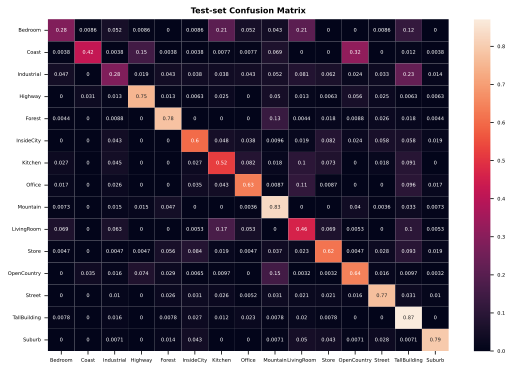

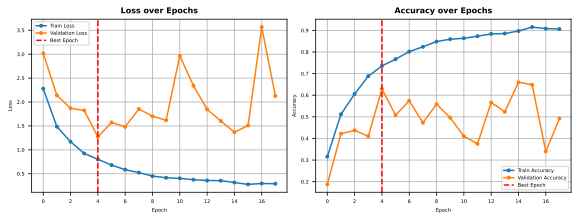



____________________________________________________________________________________________________________
TEST-SET STATISTICS:
Accuracy of the network on the test set: 58 %


Staring epoch   0 ...
   ACCURACY: train 32.5 % | validation 34.4 %
       LOSS: train  2.202 | validation  2.303
Staring epoch   1 ...
   ACCURACY: train 50.9 % | validation 35.9 %
       LOSS: train  1.507 | validation  3.748
Staring epoch   2 ...
   ACCURACY: train 64.0 % | validation 36.7 %
       LOSS: train  1.112 | validation  2.343
Staring epoch   3 ...
   ACCURACY: train 69.1 % | validation 53.9 %
       LOSS: train  0.918 | validation  1.703
Staring epoch   4 ...
   ACCURACY: train 75.7 % | validation 44.5 %
       LOSS: train  0.712 | validation  1.880
Staring epoch   5 ...
   ACCURACY: train 78.8 % | validation 56.6 %
       LOSS: train  0.636 | validation  1.426
Staring epoch   6 ...
   ACCURACY: train 82.5 % | validation 44.5 %
       LOSS: train  0.518 | validation  2.082
Staring epoch   7 ...


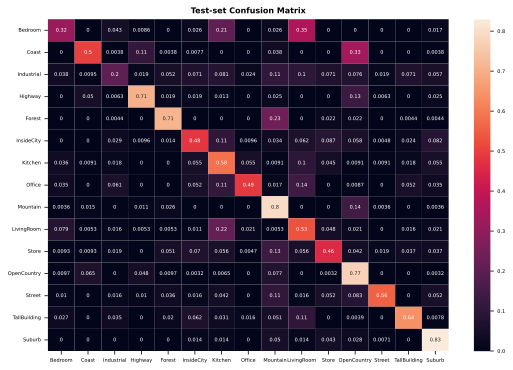

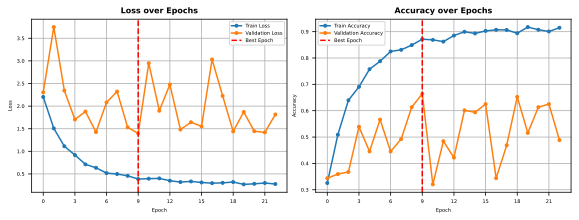



____________________________________________________________________________________________________________
TEST-SET STATISTICS:
Accuracy of the network on the test set: 63 %


Staring epoch   0 ...
   ACCURACY: train 30.4 % | validation 27.0 %
       LOSS: train  2.306 | validation  2.435
Staring epoch   1 ...
   ACCURACY: train 48.1 % | validation 25.8 %
       LOSS: train  1.604 | validation  3.160
Staring epoch   2 ...
   ACCURACY: train 59.4 % | validation 37.1 %
       LOSS: train  1.237 | validation  2.251
Staring epoch   3 ...
   ACCURACY: train 65.4 % | validation 57.8 %
       LOSS: train  1.044 | validation  1.661
Staring epoch   4 ...
   ACCURACY: train 70.1 % | validation 36.3 %
       LOSS: train  0.882 | validation  1.991
Staring epoch   5 ...
   ACCURACY: train 74.1 % | validation 61.3 %
       LOSS: train  0.755 | validation  1.339
Staring epoch   6 ...
   ACCURACY: train 78.8 % | validation 55.5 %
       LOSS: train  0.637 | validation  1.570
Staring epoch   7 ...


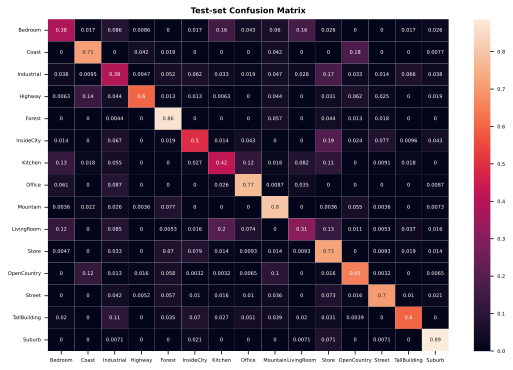

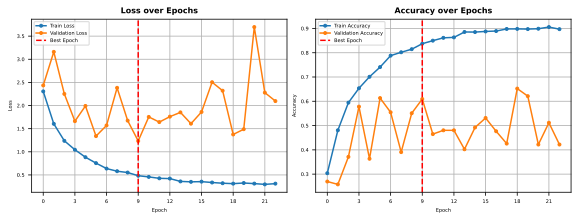



____________________________________________________________________________________________________________
TEST-SET STATISTICS:
Accuracy of the network on the test set: 59 %


Staring epoch   0 ...
   ACCURACY: train 31.3 % | validation 20.3 %
       LOSS: train  2.296 | validation  2.571
Staring epoch   1 ...
   ACCURACY: train 46.8 % | validation 46.1 %
       LOSS: train  1.642 | validation  1.765
Staring epoch   2 ...
   ACCURACY: train 58.7 % | validation 34.4 %
       LOSS: train  1.244 | validation  2.386
Staring epoch   3 ...
   ACCURACY: train 65.5 % | validation 46.5 %
       LOSS: train  1.007 | validation  1.910
Staring epoch   4 ...
   ACCURACY: train 72.0 % | validation 57.0 %
       LOSS: train  0.821 | validation  1.604
Staring epoch   5 ...
   ACCURACY: train 76.7 % | validation 58.2 %
       LOSS: train  0.684 | validation  1.513
Staring epoch   6 ...
   ACCURACY: train 78.8 % | validation 52.3 %
       LOSS: train  0.618 | validation  1.767
Staring epoch   7 ...


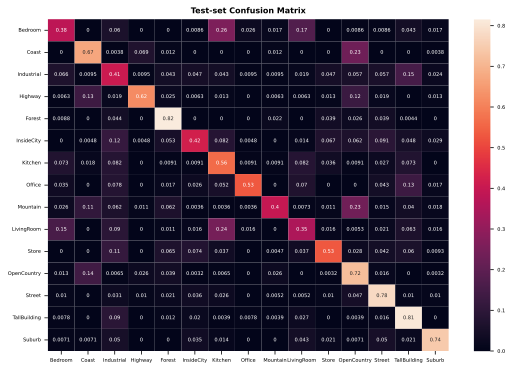

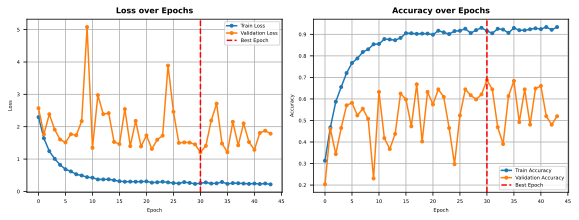



____________________________________________________________________________________________________________
TEST-SET STATISTICS:
Accuracy of the network on the test set: 64 %




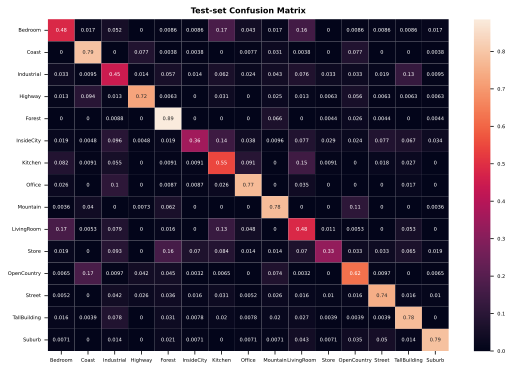

In [ ]:
n_realizations = 5

results =[]

for i in range(n_realizations):
  _, test_accuracy, __ = train_CNN(model=CNN_2(0.01), MAX_epochs=60, MAX_patience= 12, learning_rate=0.001, train_loader=train_set, validation_loader=val_set, test_loader=test_set, regularization_rate=0.008, optimizer_function=optim.Adam)
  results.append(test_accuracy)

results_df['CNN2'] = results

### Ensemble of networks

In [ ]:
# Define a function that performs training for an ensemble of networks
def train_ensemble_of_networks(MAX_epochs, MAX_patience, learning_rate, momentum=0, train_loader=train_set,
                                  validation_loader=val_set, test_loader=test_set,
                                  show_update_loss_acc = True, show_plots_loss_acc = True, model_function=CNN_2,
                                  initial_weights_std=0.01, regularization_rate=0, optimizer_function= optim.SGD, num_networks=5,
                               ############
                               show_confusion_matrix= False
                               ##############
                               ):

    models=[]

    # Init all models
    for _ in range (num_networks):
        models.append(model_function(initial_weights_std= initial_weights_std))

    # Define loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizers=[]
    if (optimizer_function== optim.SGD):
        for model in models:
            optimizers.append(optim.SGD(model.parameters(), lr= learning_rate, momentum = momentum, weight_decay= regularization_rate))
    elif(optimizer_function== optim.Adam):
        for model in models:
            optimizers.append(optim.Adam(model.parameters(), lr= learning_rate, weight_decay= regularization_rate))
    else:
        raise ValueError("Only optim.SGD or optim.Adam are supported")


    # Some variables for tracking performance
    best_validation_loss = np.full(num_networks, np.inf)
    best_epoch = np.full(num_networks, 0)
    validation_loss = [None] *num_networks # Tracking validation loss during training
    train_loss = [None] *num_networks # Tracking train loss during training
    validation_accuracy = [None] *num_networks # Tracking validation accuracy during training
    train_accuracy = [None] *num_networks # Tracking train accuracy during training
    models_paths=[None] *num_networks
    best_epochs=[None] *num_networks # Epochs of best models

    # Start training!
    for i in range (num_networks): # Train all networks

        # Current time stamp
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

        # Patience for early stopping algorithm
        patience_counter = 0

        # Some variables for tracking performance of current network
        validation_loss[i]=list({})
        train_loss[i]=list({})
        validation_accuracy[i]=list({})
        train_accuracy[i]=list({})

        print ('Training network {:>3d} ...'.format(i))


        for epoch in range(MAX_epochs): # Train each network MAX_epochs times

            print('Staring epoch {:>3d} ...'.format(epoch))

            # Make sure gradient tracking is on, and do a pass over the data
            models[i].train(True)
            t_loss, t_accuracy = train_one_epoch(models[i], loss_function, optimizers[i], train_loader)

            # Append current loss and accuracy on the training set
            train_loss[i].append(t_loss)
            train_accuracy[i].append(t_accuracy)

            # If using dropout and/or batch normalization , we need the following, to set the model to evaluation mode, disabling dropout and using population
            #   statistics for batch normalization.
            models[i].eval()

            # Evaluate loss and accuracy on validation set
            running_validation_loss = 0.0
            running_validation_accuracy = 0.0
            with torch.no_grad(): # Disable gradient computation and reduce memory consumption.
                for j, v_data in enumerate(validation_loader):
                    v_inputs, v_labels = v_data
                    v_outputs = models[i](v_inputs)
                    # Loss
                    v_loss = loss_function(v_outputs, v_labels)
                    running_validation_loss += v_loss
                    # Accuracy
                    v_accuracy = accuracy(v_labels, v_outputs)
                    running_validation_accuracy += v_accuracy
            current_validation_loss = running_validation_loss / len(validation_loader)
            current_validation_accuracy = running_validation_accuracy / len(validation_loader)
            # Append average validation loss and accuracy
            validation_loss[i].append(current_validation_loss)
            validation_accuracy[i].append(current_validation_accuracy)


            # Display progresses
            if show_update_loss_acc:
                print('   ACCURACY: train {:>4.1f} % | validation {:4.1f} %'.format(t_accuracy*100, current_validation_accuracy*100))
                print('       LOSS: train {:>6.3f} | validation {:>6.3f}'.format(t_loss, current_validation_loss))


            # Patience for early stopping
            patience_counter = patience_counter + 1

            # Track best performance (based on validation), and save the model
            if current_validation_loss < best_validation_loss[i]:
                timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
                best_validation_loss[i] = current_validation_loss
                models_paths[i] = '/content/model_{}'.format(timestamp) # Only the best model will be available at the end of the training
                torch.save(models[i].state_dict(), models_paths[i])
                best_epochs[i] = epoch
                patience_counter = 0

            # Check for early stopping
            if patience_counter > MAX_patience:
                break



    # Display some statistics
    print("\n")
    print("TRAINING ENDED!")
    print("\n")
    print("============================================================================================================")
    print("TRAINING- and VALIDATION-SET STATISTICS")

    for i in range (num_networks):
        print(f"Best model for netork {i} obtained in epoch: {best_epochs[i]}")

    # Final loss and accuracy plots
    if show_plots_loss_acc:
        for i in range (num_networks):
            print(f"Model {i} results:")
            plot_loss_acc(best_epochs[i], train_loss[i], validation_loss[i], train_accuracy[i], validation_accuracy[i])
    print("\n")


    # load the best model and evaluate the performance on the test set
    best_models= [None] *num_networks
    for i in range (num_networks):
        best_models[i]=model_function(initial_weights_std)
        best_models[i].load_state_dict(torch.load(models_paths[i]))

    print("____________________________________________________________________________________________________________")
    print("TEST-SET STATISTICS:")

    y_pred = []
    y_true = []

    # Evaluate loss and accuracy on test set
    correct = 0
    total = 0
    current_test_accuracy = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # Compute the outputs of the models
            outputs = [model(images) for model in best_models]

            stacked_outputs = torch.stack(outputs, dim=0)

            # Compute networs' outputs means for each output channel
            mean_outputs = torch.mean(stacked_outputs, dim=0)

            # Compute ensamble output
            _, predicted = torch.max(mean_outputs.data, 1)

            current_test_accuracy += accuracy(labels, mean_outputs)

            y_pred.extend(predicted) # Save Prediction
            y_true.extend(labels) # Save Truth

    test_accuracy = current_test_accuracy / len(test_loader)
    print('Accuracy of the ensemble on the test set: %d %%' % (100 * test_accuracy))

    #######################################
    if show_confusion_matrix:
        print("\n")
        classes=list(class_mapping.keys())
        cf_matrix = confusion_matrix(y_true, y_pred)
        df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes], columns = [i for i in classes])
        plt.figure(figsize = (9,6))
        plt.title("Test-set Confusion Matrix", fontsize=8, fontweight='bold')
        sn.heatmap(df_cm, annot=True)
        #plt.savefig('output.png'
    #####################################


    return best_models, test_accuracy, best_epochs

#### Testing ensemble of networks

Training network   0 ...
Staring epoch   0 ...
Staring epoch   1 ...
Staring epoch   2 ...
Staring epoch   3 ...
Staring epoch   4 ...
Staring epoch   5 ...
Staring epoch   6 ...
Staring epoch   7 ...
Staring epoch   8 ...
Staring epoch   9 ...
Staring epoch  10 ...
Staring epoch  11 ...
Staring epoch  12 ...
Staring epoch  13 ...
Staring epoch  14 ...
Staring epoch  15 ...
Staring epoch  16 ...
Staring epoch  17 ...
Staring epoch  18 ...
Staring epoch  19 ...
Staring epoch  20 ...
Staring epoch  21 ...
Training network   1 ...
Staring epoch   0 ...
Staring epoch   1 ...
Staring epoch   2 ...
Staring epoch   3 ...
Staring epoch   4 ...
Staring epoch   5 ...
Staring epoch   6 ...
Staring epoch   7 ...
Staring epoch   8 ...
Staring epoch   9 ...
Staring epoch  10 ...
Staring epoch  11 ...
Staring epoch  12 ...
Staring epoch  13 ...
Staring epoch  14 ...
Staring epoch  15 ...
Staring epoch  16 ...
Staring epoch  17 ...
Staring epoch  18 ...
Staring epoch  19 ...
Staring epoch  20 ...
Star

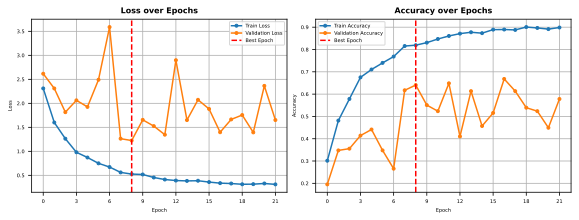

Model 1 results:




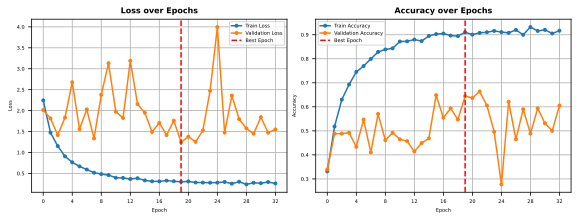

Model 2 results:




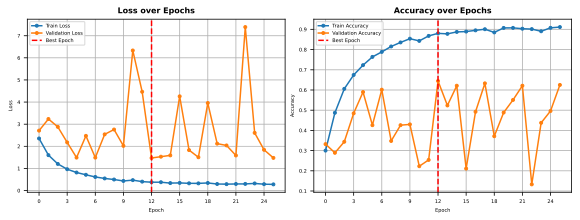

Model 3 results:




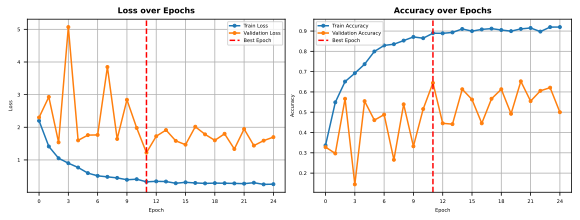

Model 4 results:




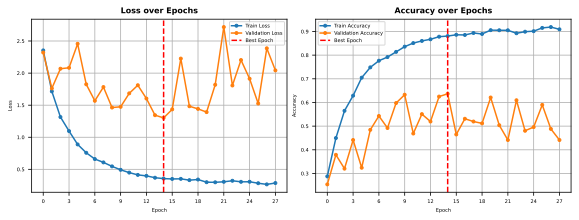



____________________________________________________________________________________________________________
TEST-SET STATISTICS:
Accuracy of the ensemble on the test set: 65 %
Training network   0 ...
Staring epoch   0 ...
Staring epoch   1 ...
Staring epoch   2 ...
Staring epoch   3 ...
Staring epoch   4 ...
Staring epoch   5 ...
Staring epoch   6 ...
Staring epoch   7 ...
Staring epoch   8 ...
Staring epoch   9 ...
Staring epoch  10 ...
Staring epoch  11 ...
Staring epoch  12 ...
Staring epoch  13 ...
Staring epoch  14 ...
Staring epoch  15 ...
Staring epoch  16 ...
Staring epoch  17 ...
Staring epoch  18 ...
Staring epoch  19 ...
Staring epoch  20 ...
Staring epoch  21 ...
Staring epoch  22 ...
Staring epoch  23 ...
Staring epoch  24 ...
Staring epoch  25 ...
Staring epoch  26 ...
Training network   1 ...
Staring epoch   0 ...
Staring epoch   1 ...
Staring epoch   2 ...
Staring epoch   3 ...
Staring epoch   4 ...
Staring epoch   5 ...
Staring epoch   6 ...
Staring epoch   7 ...
S

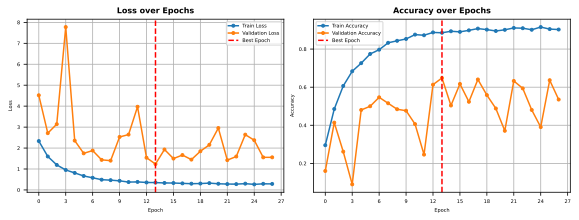

Model 1 results:




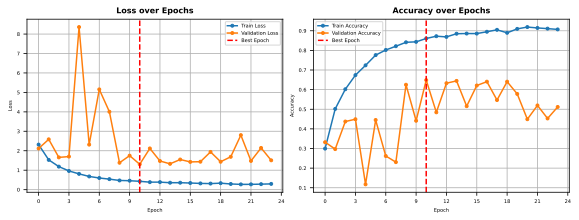

Model 2 results:




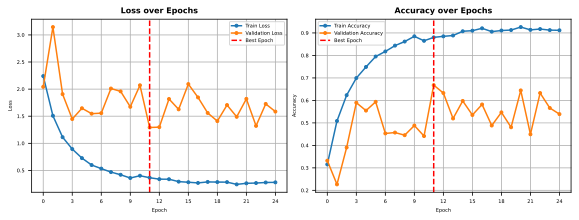

Model 3 results:




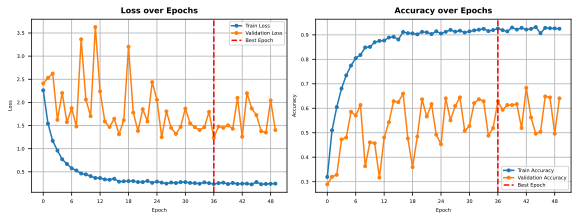

Model 4 results:




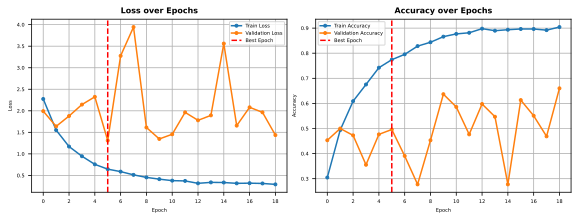



____________________________________________________________________________________________________________
TEST-SET STATISTICS:
Accuracy of the ensemble on the test set: 66 %
Training network   0 ...
Staring epoch   0 ...
Staring epoch   1 ...
Staring epoch   2 ...
Staring epoch   3 ...
Staring epoch   4 ...
Staring epoch   5 ...
Staring epoch   6 ...
Staring epoch   7 ...
Staring epoch   8 ...
Staring epoch   9 ...
Staring epoch  10 ...
Staring epoch  11 ...
Staring epoch  12 ...
Staring epoch  13 ...
Staring epoch  14 ...
Staring epoch  15 ...
Staring epoch  16 ...
Staring epoch  17 ...
Staring epoch  18 ...
Staring epoch  19 ...
Staring epoch  20 ...
Staring epoch  21 ...
Staring epoch  22 ...
Training network   1 ...
Staring epoch   0 ...
Staring epoch   1 ...
Staring epoch   2 ...
Staring epoch   3 ...
Staring epoch   4 ...
Staring epoch   5 ...
Staring epoch   6 ...
Staring epoch   7 ...
Staring epoch   8 ...
Staring epoch   9 ...
Staring epoch  10 ...
Staring epoch  11 ...
S

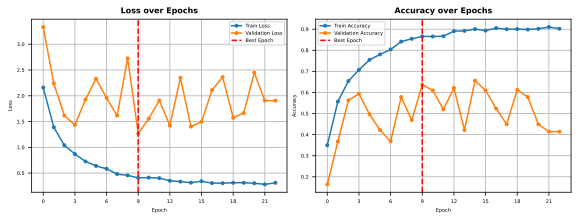

Model 1 results:




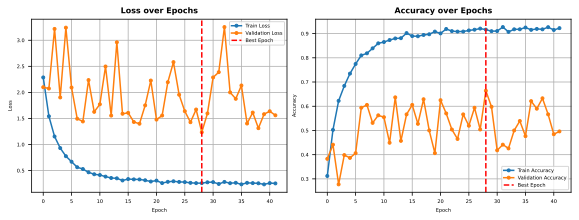

Model 2 results:




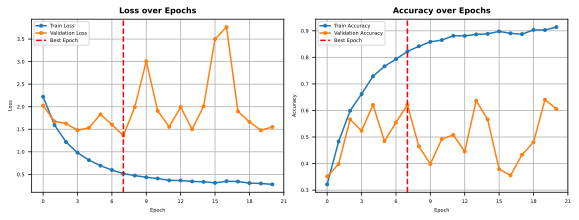

Model 3 results:




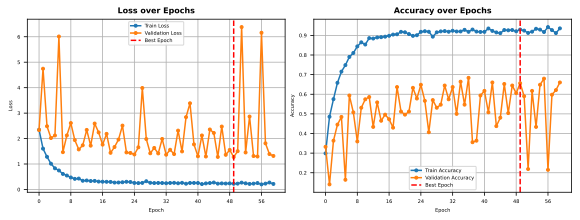

Model 4 results:




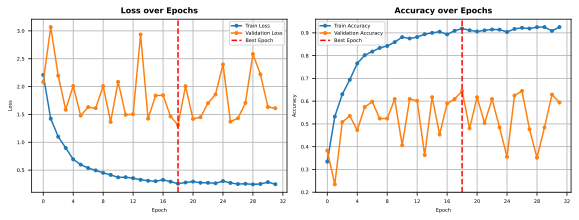



____________________________________________________________________________________________________________
TEST-SET STATISTICS:
Accuracy of the ensemble on the test set: 67 %
Training network   0 ...
Staring epoch   0 ...
Staring epoch   1 ...
Staring epoch   2 ...
Staring epoch   3 ...
Staring epoch   4 ...
Staring epoch   5 ...
Staring epoch   6 ...
Staring epoch   7 ...
Staring epoch   8 ...
Staring epoch   9 ...
Staring epoch  10 ...
Staring epoch  11 ...
Staring epoch  12 ...
Staring epoch  13 ...
Staring epoch  14 ...
Staring epoch  15 ...
Staring epoch  16 ...
Staring epoch  17 ...
Staring epoch  18 ...
Staring epoch  19 ...
Staring epoch  20 ...
Staring epoch  21 ...
Staring epoch  22 ...
Staring epoch  23 ...
Staring epoch  24 ...
Staring epoch  25 ...
Staring epoch  26 ...
Staring epoch  27 ...
Staring epoch  28 ...
Staring epoch  29 ...
Staring epoch  30 ...
Staring epoch  31 ...
Staring epoch  32 ...
Staring epoch  33 ...
Staring epoch  34 ...
Staring epoch  35 ...
Star

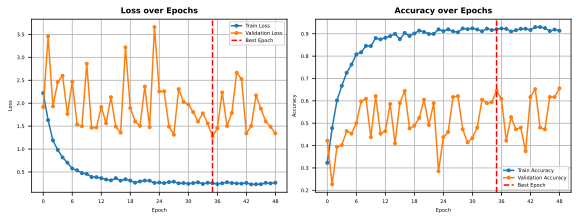

Model 1 results:




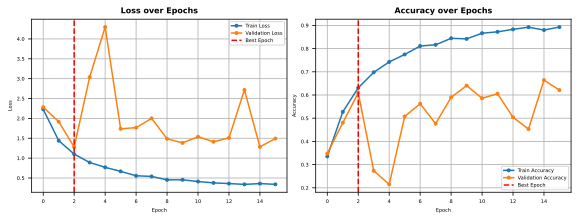

Model 2 results:




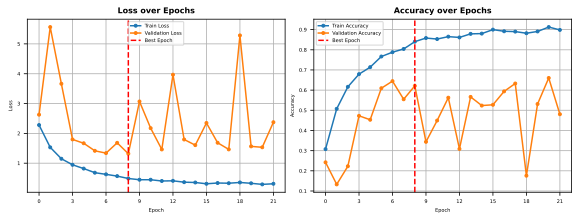

Model 3 results:




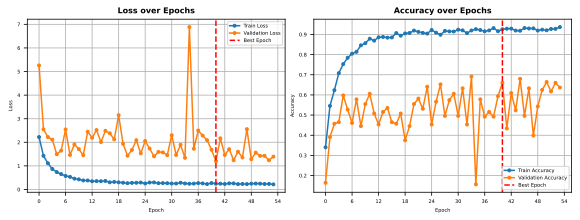

Model 4 results:




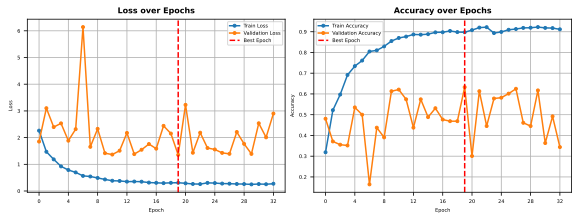



____________________________________________________________________________________________________________
TEST-SET STATISTICS:
Accuracy of the ensemble on the test set: 65 %
Training network   0 ...
Staring epoch   0 ...
Staring epoch   1 ...
Staring epoch   2 ...
Staring epoch   3 ...
Staring epoch   4 ...
Staring epoch   5 ...
Staring epoch   6 ...
Staring epoch   7 ...
Staring epoch   8 ...
Staring epoch   9 ...
Staring epoch  10 ...
Staring epoch  11 ...
Staring epoch  12 ...
Staring epoch  13 ...
Staring epoch  14 ...
Staring epoch  15 ...
Staring epoch  16 ...
Staring epoch  17 ...
Staring epoch  18 ...
Staring epoch  19 ...
Staring epoch  20 ...
Staring epoch  21 ...
Staring epoch  22 ...
Staring epoch  23 ...
Staring epoch  24 ...
Staring epoch  25 ...
Staring epoch  26 ...
Staring epoch  27 ...
Staring epoch  28 ...
Staring epoch  29 ...
Staring epoch  30 ...
Staring epoch  31 ...
Staring epoch  32 ...
Training network   1 ...
Staring epoch   0 ...
Staring epoch   1 ...
S

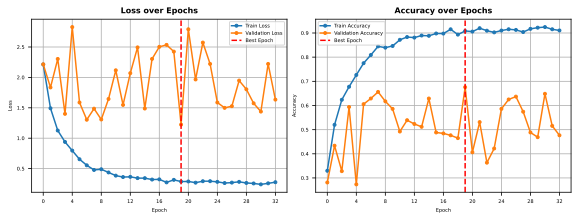

Model 1 results:




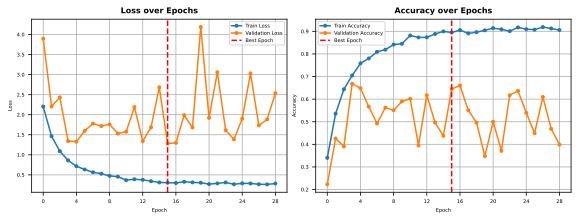

Model 2 results:




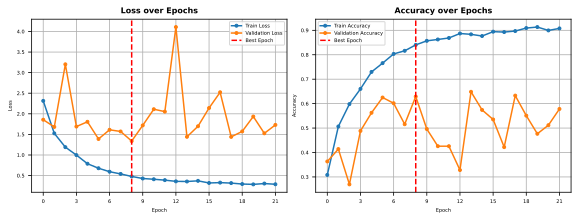

Model 3 results:




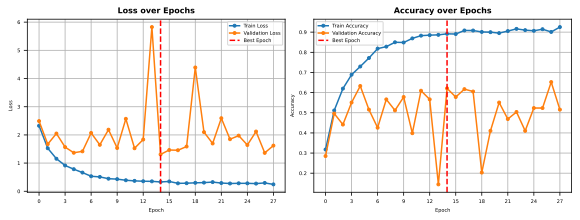

Model 4 results:




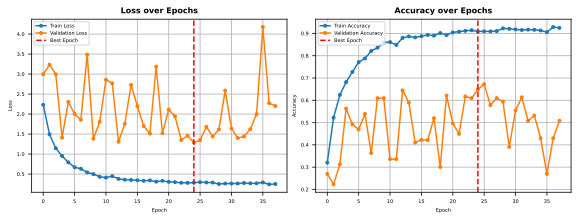



____________________________________________________________________________________________________________
TEST-SET STATISTICS:
Accuracy of the ensemble on the test set: 66 %


In [ ]:
results = []

for i in range (n_realizations):
   _, test_accuracy, __ = train_ensemble_of_networks(60, 12, 0.001, train_loader = train_set, validation_loader = val_set, test_loader = test_set, show_update_loss_acc=False,  initial_weights_std=0.01, regularization_rate=0.008, optimizer_function=optim.Adam, num_networks=5)
   results.append(test_accuracy)

results_df['Ensamble of networks'] = results

### CNN_3

In [ ]:
# Model that adds some layers to CNN_2
class CNN_3(nn.Module):
    def __init__(self, initial_weights_std):
        super(CNN_3, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout1 = nn.Dropout(p=0.25)


        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout2 = nn.Dropout(p=0.25)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=7, padding=3)
        self.bn3 = nn.BatchNorm2d(32)
        self.relu3 = nn.ReLU()

        ####################################
        # Added layers
        self.convAdded = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=9, padding=4)
        self.bnAdded = nn.BatchNorm2d(32)
        self.reluAdded = nn.ReLU()

        self.fcAdded = nn.Linear(32 * 16 * 16, 256)
        ####################################

        self.dropout3 = nn.Dropout(p=0.25)

        self.fc4 = nn.Linear(256, 15) # In_features modified

        #self.softmax5 = nn.Softmax(dim=1)

        self.initial_weigths_std= initial_weights_std

        self.initialize_weights()


    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.normal_(m.weight, mean=0, std=self.initial_weigths_std)
                init.constant_(m.bias, 0)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        ####################################
        # Added layers
        x = self.convAdded(x)
        x = self.bnAdded(x)
        x = self.reluAdded(x)
        x = x.view(-1, 32 * 16 * 16)
        x = self.fcAdded(x)
        ####################################

        x = self.dropout3(x)

        x = x.view(-1, 256) # modified
        x = self.fc4(x)

        #x = self.softmax5(x)

        return x

#### Testing CNN_3

Staring epoch   0 ...
   ACCURACY: train 27.2 % | validation 23.8 %
       LOSS: train  2.287 | validation  2.263
Staring epoch   1 ...
   ACCURACY: train 40.0 % | validation 48.4 %
       LOSS: train  1.833 | validation  1.652
Staring epoch   2 ...
   ACCURACY: train 47.9 % | validation 33.6 %
       LOSS: train  1.575 | validation  2.953
Staring epoch   3 ...
   ACCURACY: train 54.7 % | validation 46.5 %
       LOSS: train  1.358 | validation  2.048
Staring epoch   4 ...
   ACCURACY: train 58.7 % | validation 37.9 %
       LOSS: train  1.215 | validation  1.878
Staring epoch   5 ...
   ACCURACY: train 61.3 % | validation 27.7 %
       LOSS: train  1.134 | validation  2.416
Staring epoch   6 ...
   ACCURACY: train 62.9 % | validation 66.4 %
       LOSS: train  1.083 | validation  1.262
Staring epoch   7 ...
   ACCURACY: train 66.4 % | validation 54.3 %
       LOSS: train  0.980 | validation  1.699
Staring epoch   8 ...
   ACCURACY: train 68.3 % | validation 36.3 %
       LOSS: train  

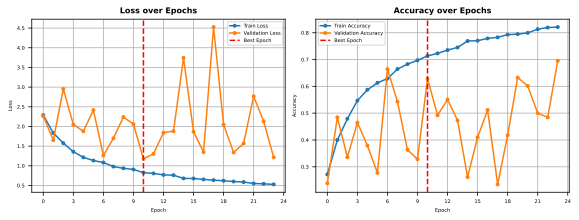



____________________________________________________________________________________________________________
TEST-SET STATISTICS:
Accuracy of the network on the test set: 59 %


Staring epoch   0 ...
   ACCURACY: train 26.8 % | validation 28.9 %
       LOSS: train  2.257 | validation  2.641
Staring epoch   1 ...
   ACCURACY: train 39.4 % | validation 41.0 %
       LOSS: train  1.841 | validation  2.165
Staring epoch   2 ...
   ACCURACY: train 47.8 % | validation 28.1 %
       LOSS: train  1.570 | validation  2.624
Staring epoch   3 ...
   ACCURACY: train 55.4 % | validation 56.2 %
       LOSS: train  1.311 | validation  1.508
Staring epoch   4 ...
   ACCURACY: train 59.0 % | validation 43.4 %
       LOSS: train  1.207 | validation  1.816
Staring epoch   5 ...
   ACCURACY: train 63.2 % | validation 40.2 %
       LOSS: train  1.101 | validation  2.962
Staring epoch   6 ...
   ACCURACY: train 65.3 % | validation 30.5 %
       LOSS: train  1.008 | validation  2.711
Staring epoch   7 ...


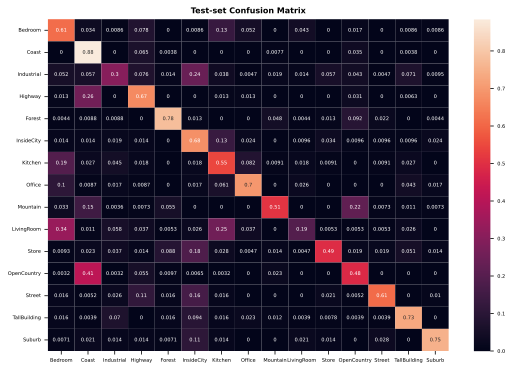

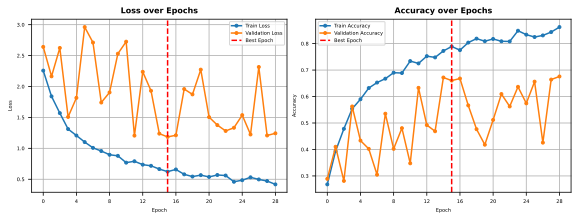



____________________________________________________________________________________________________________
TEST-SET STATISTICS:
Accuracy of the network on the test set: 56 %


Staring epoch   0 ...
   ACCURACY: train 27.7 % | validation 23.0 %
       LOSS: train  2.232 | validation  2.599
Staring epoch   1 ...
   ACCURACY: train 44.4 % | validation 10.5 %
       LOSS: train  1.675 | validation  6.603
Staring epoch   2 ...
   ACCURACY: train 52.7 % | validation 48.0 %
       LOSS: train  1.404 | validation  1.716
Staring epoch   3 ...
   ACCURACY: train 58.6 % | validation 46.5 %
       LOSS: train  1.255 | validation  1.739
Staring epoch   4 ...
   ACCURACY: train 61.1 % | validation 27.0 %
       LOSS: train  1.133 | validation  3.503
Staring epoch   5 ...
   ACCURACY: train 64.3 % | validation 41.0 %
       LOSS: train  1.069 | validation  2.035
Staring epoch   6 ...
   ACCURACY: train 67.0 % | validation 44.9 %
       LOSS: train  0.970 | validation  1.580
Staring epoch   7 ...


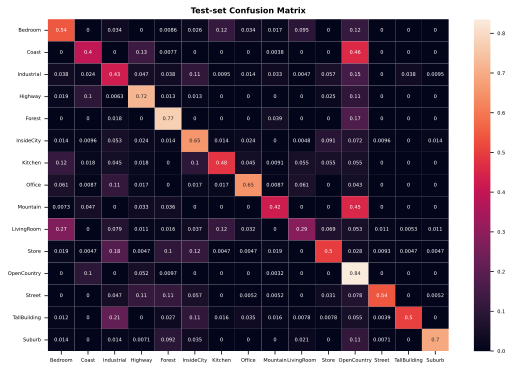

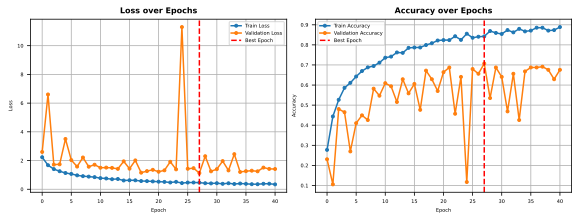



____________________________________________________________________________________________________________
TEST-SET STATISTICS:
Accuracy of the network on the test set: 64 %


Staring epoch   0 ...
   ACCURACY: train 26.9 % | validation 30.1 %
       LOSS: train  2.242 | validation  2.143
Staring epoch   1 ...
   ACCURACY: train 41.0 % | validation 14.8 %
       LOSS: train  1.770 | validation  4.171
Staring epoch   2 ...
   ACCURACY: train 52.0 % | validation 27.0 %
       LOSS: train  1.439 | validation  2.557
Staring epoch   3 ...
   ACCURACY: train 56.5 % | validation 44.9 %
       LOSS: train  1.275 | validation  1.925
Staring epoch   4 ...
   ACCURACY: train 60.8 % | validation 51.2 %
       LOSS: train  1.163 | validation  1.792
Staring epoch   5 ...
   ACCURACY: train 63.6 % | validation 55.1 %
       LOSS: train  1.072 | validation  1.524
Staring epoch   6 ...
   ACCURACY: train 66.3 % | validation 33.6 %
       LOSS: train  0.984 | validation  1.885
Staring epoch   7 ...


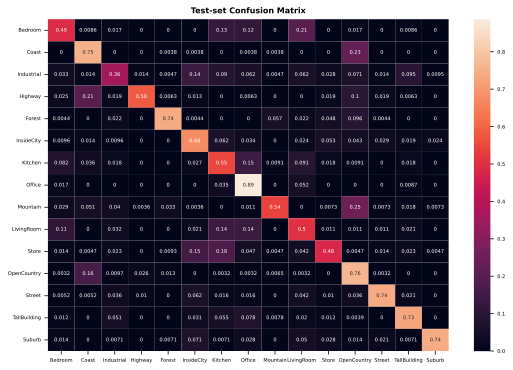

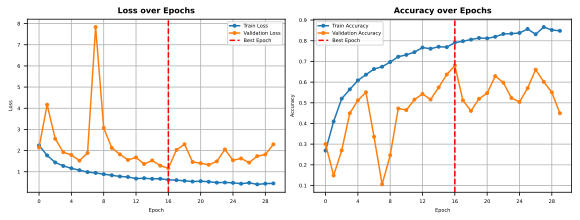



____________________________________________________________________________________________________________
TEST-SET STATISTICS:
Accuracy of the network on the test set: 63 %


Staring epoch   0 ...
   ACCURACY: train 27.4 % | validation 17.2 %
       LOSS: train  2.287 | validation  2.631
Staring epoch   1 ...
   ACCURACY: train 43.2 % | validation 38.7 %
       LOSS: train  1.758 | validation  2.315
Staring epoch   2 ...
   ACCURACY: train 51.7 % | validation 21.1 %
       LOSS: train  1.467 | validation  2.788
Staring epoch   3 ...
   ACCURACY: train 56.2 % | validation  9.8 %
       LOSS: train  1.281 | validation  9.194
Staring epoch   4 ...
   ACCURACY: train 61.6 % | validation 50.4 %
       LOSS: train  1.139 | validation  1.897
Staring epoch   5 ...
   ACCURACY: train 62.7 % | validation 35.9 %
       LOSS: train  1.103 | validation  1.940
Staring epoch   6 ...
   ACCURACY: train 66.6 % | validation 40.2 %
       LOSS: train  0.991 | validation  2.294
Staring epoch   7 ...


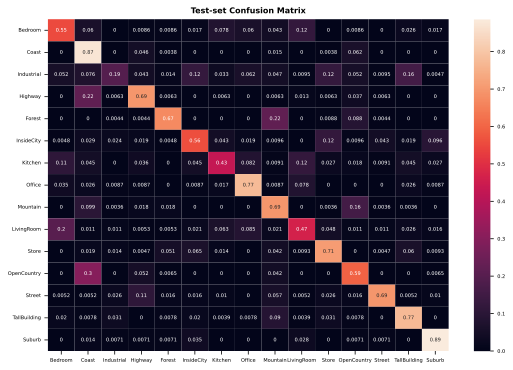

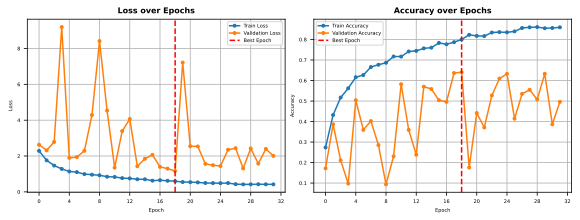



____________________________________________________________________________________________________________
TEST-SET STATISTICS:
Accuracy of the network on the test set: 64 %




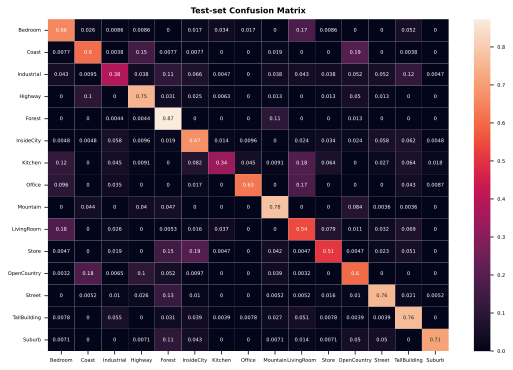

In [ ]:
results = []

for i in range (n_realizations):
   _, test_accuracy, __ = train_CNN(model=CNN_3(0.01), MAX_epochs=60, MAX_patience= 12, learning_rate=0.001, train_loader=train_set, validation_loader=val_set, test_loader=test_set, regularization_rate=0.008, optimizer_function=optim.Adam)
   results.append(test_accuracy)

results_df['CNN3'] = results

In [ ]:
results_df.to_csv('exp_2.csv', index=False)

### Results analysis

In [ ]:
df = pd.read_csv('exp_2.csv')
df

CNN2  Ensamble of networks      CNN3
0  0.630762              0.657173  0.594009
1  0.586215              0.669917  0.560062
2  0.633090              0.670804  0.640403
3  0.591977              0.659685  0.638667
4  0.640699              0.663158  0.648899

In [ ]:
# Compute sample average accuracy for each experiment
df_average_accuracy = df.mean()

# Descending order
df_average_accuracy = df_average_accuracy.sort_values(ascending=False)

df_average_accuracy

Experiment   |   Average accuracy (descending order):

Ensamble of networks    0.664147
CNN2                    0.616548
CNN3                    0.616408
dtype: float64


In [ ]:
# Compute sample variance of accuracy for each experiment
df_accuracy_variance = df.var()

df_accuracy_variance

CNN2                    0.000646
Ensamble of networks    0.000037
CNN3                    0.001451
dtype: float64

In [ ]:
print(f"                        ACCURACY                        ")
print(f"________________________________________________________")
print(f"      Experiment         |     Mean     |   Variance   |")
print(f"_________________________|______________|______________|")
for column in df_average_accuracy.index:
    print(f"{column:<25}|   {df_average_accuracy[column]:.6f}   |   {df_accuracy_variance[column]:.6f}   |")

                        ACCURACY                        
________________________________________________________
      Experiment         |     Mean     |   Variance   |
_________________________|______________|______________|
CNN2                     |   0.616548   |   0.000646   |
Ensamble of networks     |   0.664147   |   0.000037   |
CNN3                     |   0.616408   |   0.001451   |


In [ ]:
from scipy.stats import ttest_ind

# Compute sample average accuracy for each experiment
means = df.mean()

# Find the experiment with highest average
max_mean_column = means.idxmax()

results = []

# Computing for each experiment (except max_average) the Welch's t-test for the null hypotesis: "max_average = other_average"
for column in df.columns:
    if column != max_mean_column:
        _, p_value = ttest_ind(df[max_mean_column], df[column], equal_var=False)

        results.append((column, p_value))

# Display resulst in descending order of p-value
results_sorted = sorted(results, key=lambda x: x[1], reverse=True)

print(f"Highest average accuracy: {df[max_mean_column].mean()}")
print(f"Best-experiment: {max_mean_column}\n\n")

print(f"Computing for each other experiment, except {max_mean_column}, the Welch's t-test for the null hypotesis: best_average == other_average")
print(f"Results are printed with p-value in descending order\n")

for result in results_sorted:
    print(f"{result[0]:<14} vs  Best-experiment:    p-value = {result[1]:.6f}")

# If p-value is smaller than the treshold, the null hypotesis is rejected

Highest average accuracy: 0.6641474586288416
Best-experiment: Ensamble of networks


Computing for each other experiment, except Ensamble of networks, the Welch's t-test for the null hypotesis: best_average == other_average
Results are printed with p-value in descending order

CNN3           vs  Best-experiment:    p-value = 0.047756
CNN2           vs  Best-experiment:    p-value = 0.012186


### Testing the best model

Training network   0 ...
Staring epoch   0 ...
   ACCURACY: train 34.1 % | validation 32.8 %
       LOSS: train  2.225 | validation  3.196
Staring epoch   1 ...
   ACCURACY: train 55.0 % | validation 34.4 %
       LOSS: train  1.402 | validation  2.065
Staring epoch   2 ...
   ACCURACY: train 64.4 % | validation 59.0 %
       LOSS: train  1.069 | validation  1.597
Staring epoch   3 ...
   ACCURACY: train 71.3 % | validation 46.5 %
       LOSS: train  0.848 | validation  2.295
Staring epoch   4 ...
   ACCURACY: train 75.5 % | validation 48.4 %
       LOSS: train  0.707 | validation  1.784
Staring epoch   5 ...
   ACCURACY: train 78.0 % | validation 54.3 %
       LOSS: train  0.641 | validation  1.814
Staring epoch   6 ...
   ACCURACY: train 82.4 % | validation 56.6 %
       LOSS: train  0.519 | validation  1.617
Staring epoch   7 ...
   ACCURACY: train 84.8 % | validation 39.5 %
       LOSS: train  0.451 | validation  2.064
Staring epoch   8 ...
   ACCURACY: train 86.6 % | validation 51

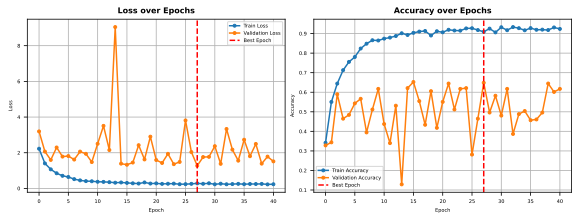

Model 1 results:




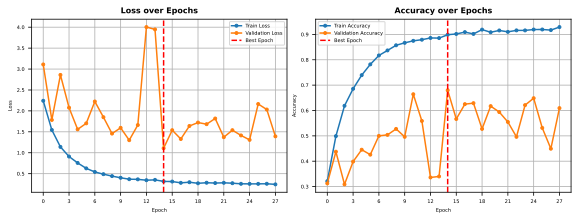

Model 2 results:




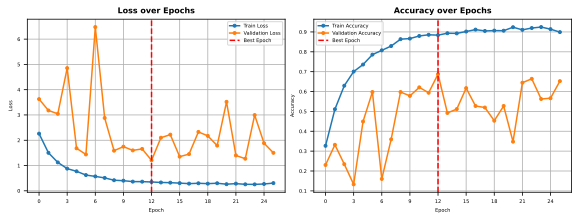

Model 3 results:




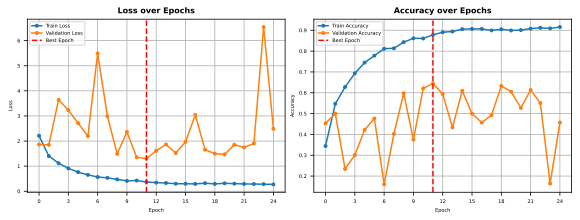

Model 4 results:




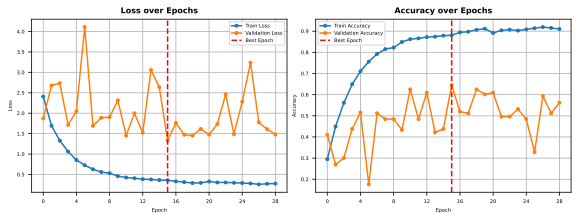



____________________________________________________________________________________________________________
TEST-SET STATISTICS:
Accuracy of the ensemble on the test set: 67 %




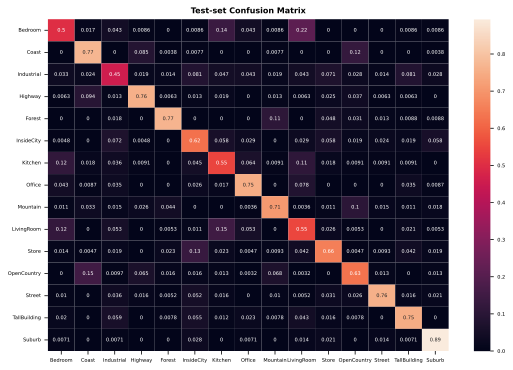

In [ ]:
_, __, ___ = train_ensemble_of_networks(60, 12, 0.001, train_loader = train_set, validation_loader = val_set, test_loader = test_set, show_update_loss_acc=True,  initial_weights_std=0.01, regularization_rate=0.008, optimizer_function=optim.Adam, num_networks=5, show_confusion_matrix=True)